## Objetivo: Quanto um cliente de um determinado perfil está disposto a gastar?

A ideia é ter uma equação que permita alteração de parâmetros para avaliar o valor que um determinado cliente gastaria em um dado cenário (definido pelos parâmetros). Nesse sentido, nossa target é o campo "Total Pago (R$)".

O cenário é o conjunto de parâmetros que nós previamente escolhemos para avaliar o potencial de gasto. Em outras palavras, as variáveis que utilizaremos para prever a nossa target. Dessa forma, ele será definido pelos campos:
- Perfil do cliente
- Categoria de item em campanha de marketing
- Desconto total oferecido
- Tempo desde a última compra
- Tempo gasto para decisão

In [105]:
import numpy as np
import pandas as pd
from typing import List
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder

BASE_PATH = "/media/bruno/Arquivos/Desenvolvimento/LaranjaLima"

## Preparação

Como nossa target é uma variável contínua, estamos diante de um problema de regressão. Antes de acessar os métodos de treino, precisamos garantir que as variáveis categóricas sejam devidamente traduzidas em números. Técnicas de encode como OneHot, Ordinal, Target e outras são úteis nesse ponto. Um cuidado que se deve ter é com relação ao modelo que será testado. Este notebook utiliza o OneHot e o Target, no intuito de demonstrar o impacto e as diferenças entre eles na modelagem.

Em linhas gerais, este tratamento seria o suficiente para o processo de modelagem, uma vez que garantimos que todos os dados de entrada são numéricos. Todavia, ainda existe uma situação comum de ocorrer: campos com dados faltantes. O valor null indica que o valor não existe e pode ser gerado por alguma regra de negócio, falta de captura de informação ou um erro qualquer de processamento. De todo modo, os algoritmos de ajuste simplesmente executam cálculos, portando não vão conseguir lidar com null, afinal não é um número. Scalers são úteis nesse sentido, onde substituímos estes campos vazios por um valor padrão, que pode ser escolhido por meio de uma estratégia qualquer (número fixo, média, mediana, moda ou qualquer outro que julgar interessante). Apesar de estarmos "inserindo" informações que não são "originais" do conjunto de dados, estamos garantindo que os outros campos com números, que podem contribuir positivamente para o modelo, serão considerados no cálculo.

Por fim, ainda podemos realizar um outro tipo de processamento, que é alterar a escala dos valores de entrada. Esse tipo de transformação faz com que não se gerem coeficientes (em modelos que utilizam eles) com grande variação de escala entre si. Deste modo, alinhando com técnicas de regularização, garantimos que variações na entrada não gerem uma variação descontrolada na saída, uma vez que os coeficientes tendem a serem menores e sem muita desigualdade de escala entre eles.

## Processo

Com os dados, tudo que precisamos fazer é invocar os métodos de ajuste de modelo e teremos um pronto para utilizar. Porém, como saber se ele é bom? Para responder essa pergunta, precisaríamos testar este modelo com dados que já conhecemos, e não foram utilizados no ajuste, para saber se o modelo é efetivo, comparando o resultado dado pelo modelo e o valor real. Assim, a estratégia é pegar a nossa base original e repartir ela em duas. Uma parte nós vamos guardar e deixar quieta, ficará "esquecida" enquanto trabalhamos em todo o processo de treino na parte que vamos chamar de *treino*.

Em outra palavras, uma parte dos dados vamos guardar e, no momento oportuno, vamos tratar ela como se fossem dados novos que acabamos de obter. Todo o nosso processo de configuração de encode, definição de metodologia de substituição de null, padronização de valores e o ajuste do modelo serão feitos apenas com a parte de *treino*. As instâncias configuradas neste momento que serão utilizadas no fluxo de predição de novos valores, onde vamos resgatar aquela parte dos dados guardados para avaliar o quão bom o modelo foi.

Nosso processo então pode ser resumido nas seguintes etapas:
1. Carregar os dados existentes;
2. Separar os dados em duas partes, uma para treino e outra para teste;
3. Definir o campo que contêm a nossa target;
4. Definir os campos das variáveis preditoras (entrada do modelo), identificando o que é categórico e o que é numérico;
5. Ajustar as instâncias de encode, substituição e padronização utilizando apenas a base de treino;
6. Aplicar as transformações definidas anteriormente nos campos que representam as variáveis de entrada;
7. Instanciar o modelo que será testado, com as devidas particularidades (hyper parâmetros);
8. Utilizar os dados transformados em (6) para ajustar o modelo instanciado em (7);
9. Definir uma métrica de avaliação;
10. Recuperar os dados de teste e aplicar as mesmas transformações de (6);
11. Avaliar o resultado da métrica definida em (9) nos dados de teste e comparar com o resultado obtido no treino;
10. Caso o modelo seja bom, utilizar em novos dados, sempre aplicando as transformações de (6) antes de utilizar o modelo.

A classe criada abaixo tem como função implementar estes passos em alto nível, permitindo que o fluxo de execução se torne mais simples e o processo se torne mais fluido de executar, com as alterações mais importantes visíveis e o processo "maçante" encapsulado nos métodos.

In [175]:
class Pipe:
    def __init__(self, df: pd.DataFrame) -> None:
        self.__base_data = df
        self.__encoder = OneHotEncoder(sparse_output=False)
        self.__imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
        self.__scaler = StandardScaler()
        self.__outliers = IsolationForest()
        self.__categorical_columns: List[str] = None
        self.__numeric_columns: List[str] = None
        self.__target_column: str = None

    def set_categorical_columns(self, columns: List[str]) -> None:
        self.__categorical_columns = columns

    def set_numeric_columns(self, columns: List[str]) -> None:
        self.__numeric_columns = columns

    def set_target_column(self, column: str) -> None:
        self.__target_column = column

    def set_encoder(self, encoder) -> None:
        self.__encoder = encoder

    def set_dataset(self, df: pd.DataFrame) -> None:
        self.__base_data = df

    def get_categorical_columns(self) -> List[str]:
        return [c for c in self.__categorical_columns]
    
    def get_numeric_columns(self) -> List[str]:
        return [c for c in self.__numeric_columns]
    
    def get_target_column(self) -> str:
        return self.__target_column

    def split(self, test=0.3) -> None:
        self.train, self.test = train_test_split(self.__base_data, test_size=test, random_state=666)

    def fit_preprocess(self) -> None:
        np_cat, np_num = self.__divide(self.train)
        if np_cat is not None:
            np_cat = self.__encoder.fit_transform(np_cat, self.train[self.__target_column].values)

        x = self.__concatenete(np_cat, np_num)
        x = self.__imputer.fit_transform(x)
        x = self.__scaler.fit_transform(x)
        self.__outliers.fit(x)

    def transform_data(self, df: pd.DataFrame) -> np.ndarray:
        np_cat, np_num = self.__divide(df)
        if np_cat is not None:
            np_cat = self.__encoder.transform(np_cat)

        x = self.__concatenete(np_cat, np_num)
        x = self.__imputer.transform(x)
        x = self.__scaler.transform(x)
        return x
    
    def train_model(self, model, remove_outliers=False) -> None:
        x = self.transform_data(self.train)
        y = self.train[self.__target_column].values

        if remove_outliers:
            outliers = self.__outliers.predict(x)
            x_train, y_train = [], []
            for i in range(0, len(outliers)):
                if outliers[i] == 1:
                    x_train.append(x[i])
                    y_train.append(y[i])
        else:
            x_train, y_train = x, y

        model.fit(x_train, y_train)

        x_test = self.transform_data(self.test)
        y_test = self.test[self.__target_column].values

        print(f"MAE treino: {mean_absolute_error(y_train, model.predict(x_train))}")
        print(f"MAE teste: {mean_absolute_error(y_test, model.predict(x_test))}")

    def predict(self, df: pd.DataFrame, model) -> np.ndarray:
        x = self.transform_data(df)
        return model.predict(x)

    def show_graphs(self, models: list):
        fig, ax = plt.subplots(len(models), 2, figsize=(20, 7 * len(models)))
        df_train = self.train.sample(100)
        df_test = self.test.sample(100)

        for i in range(0, len(models)):
            # De acordo com a quantidade de linhas do subplot, altera a forma de acesso
            if len(models) == 1: axi = ax
            else: axi = ax[i]

            # Configura a exibição da performance em treino
            x = [j for j in range(0, len(df_train))]
            real = df_train[self.__target_column].values
            pred = self.predict(df_train, models[i])
            axi[0].set_ylabel("R$ gasto")
            axi[0].set_xlabel("Observação")
            axi[0].scatter(x, real, color="#000000", s=8, label="Real")
            axi[0].scatter(x, pred, color="#567a0d", s=8, label="Predição")
            axi[0].set_title(f"Performance no treino do modelo {models[i].__class__.__name__}", fontdict={"fontsize": 14}, pad=10)
            for j in range(0, len(x)):
                axi[0].vlines(j, ymax=real[j], ymin=pred[j], colors="#888888")
            axi[0].legend()

            # Configura a exibição da performance em teste
            x = [j for j in range(0, len(df_test))]
            real = df_test[self.__target_column].values
            pred = self.predict(df_test, models[i])
            axi[1].set_ylabel("R$ gasto")
            axi[1].set_xlabel("Observação")
            axi[1].scatter(x, real, color="#000000", s=8, label="Real")
            axi[1].scatter(x, pred, color="#567a0d", s=8, label="Predição")
            axi[1].set_title(f"Performance no teste do modelo {models[i].__class__.__name__}", fontdict={"fontsize": 14}, pad=10)
            for j in range(0, len(x)):
                axi[1].vlines(j, ymax=real[j], ymin=pred[j], colors="#888888")
            axi[1].legend()
        
        plt.show()
    
    def __divide(self, df: pd.DataFrame) -> List[np.ndarray]:
        if self.__categorical_columns is None and self.__numeric_columns is not None:
            return None, df[self.__numeric_columns].values
        
        if self.__categorical_columns is not None and self.__numeric_columns is None:
            return df[self.__categorical_columns].values, None
        
        return df[self.__categorical_columns].values, df[self.__numeric_columns].values
    
    def __concatenete(self, np1: np.ndarray=None, np2: np.ndarray=None):
        if np1 is None and np2 is not None:
            return np2
        if np2 is None and np1 is not None:
            return np1
        
        return np.concatenate((np1, np2), axis=1)

## Escolhendo o modelo

O processo para executar o ajuste de um modelo qualquer é sempre o mesmo, com pequenas alterações de acordo com a particularidade do modelo, como alterar o tipo de estratégia de encode para categóricas. Para saber se é necessário alguma alteração, basta conhecer o processo matemático utilizado pelo modelo. O scikit-learn possui uma documentação geral sobre as técnicas implementadas, é bom sempre conferir [aqui](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

Neste notebook vamos utilizar três modelos regressivos no intuito de explorar algumas particularidades de cada. São eles: linear, máquinas de suporte e árvore de decisão. Também vamos utilizar as ávores randômicas, que na verdade é um ensemble de árvores de decisão. Na maioria das vezes em problemas de regressão, modelos lineares são bem úteis: rápidos e com uma capacidade de predição razoável, mas nosso intuito neste momento é explorar um pouco mais sobre as particularidades. A escolha do modelo não é simplemente aleatória, é uma combinação entre conhecimento técnico e conhecimento de negócio, que permite identificar em qual modelagem o problema melhor se encaixa.

## Avaliando métricas

Para ser fácil de interpretar, vamos utilizar o erro absoluto médio (MAE). Lembrando que esta não é a função de perda utilizada na modelagem, vamos utilizar o MAE na nossa avaliação e comparação entre performance no treino e teste, já que o resultado do MAE, no nosso caso, será um valor em Real e não $Real^2$, como no caso do MSE.

De modo geral, os modelos de máquinas de suporte e linear não apresentam indícios de overfitting, já que não vemos um baixo valor de MAE no treino e um alto valor no teste. O caso contrário acontece com árvores, onde percebemos claramente um overfitting. De fato, modelos de árvores, quando muito grandes ou com diversos parâmetros, tendem ao overfitting, assim o nosso trabalho é alterar algo para quebrar esse fato.

Algo importante é que, ao olharmos os gráficos representativos da previsão no treino e no teste, percebemos que os modelos de máquinas de suporte e linear são incapazes de prever valores altos. Em outras palavras, estamos diante de um caso de modelos com alto viés. Mesmo removendo a regularização ou alterando os parâmetros, não conseguimos chegar em uma situação onde quebramos o viés destes modelos.

Por outro lado, a troca de parâmetros aparenta ter um impacto maior no modelo de árvore. Obviamente, como em casos de regressão as folhas das árvores atuam como preditores não contínuos, ou seja, seus valores vão sempre ser espelhos do que foi apresentado no treino, ainda teremos um forte overfitting e uma baixa capacidade de predição. Alterar o tamanho máximo da árvore também ajuda na quebra do overfitting, impedindo que a árvore crie nós extremamente especializados nos dados utilizados no treino.

## Trocando o encoder

A troca do padrão do One Hot Endoer pelo Target Encoder apresentou uma redução pequena no erro dos modelos, principalmente nas árvores. Isso significa que o modelo, no caso trabalhado. ainda conseguiu lidar bem com as dimensões novas criadas.

Sobre o Target, é importante pontuar que, nos casos de modelos influenciados pela escala dos valores de entrada, quando utilizamos o One Hot geralmente podemos ignorar estas colunas na padronização, porém ao usar o Target, essa nova coluna precisa entrar no fluxo de padronização. A classe que implementamos para padronizar os passos do processamento, por definição, sempre aplica a substituição de nulos e padronização de escala em toda a matriz de entrada, porém é importante ter noção de que em alguns casos podemos aplicar ou não esta técnica em determinadas colunas.

## Ovservações sobre as árvores

Por definição, árvores não precisam de encoder de variáveis e nem de padronização de valores, uma vez que elas trabalham com a metodologia de regras e split. Assim, poderíamos fornecer variáveis categóricas diretamente para as árvores. Porém, até a versão em que este notebook foi criado, o modelo implementado no scikit-learn não permite a entrada de dados categóricos no modelo de árvores implementado na biblioteca, portando precisamos converter as categorias em números.

Em linhas gerais, isso não é um grande problema, porém para árvores existe um pequeno detalhe: este modelo tende ao overfitting, principalmente com o aumento do número de features. Assim, é preciso ter cuidado com encoders que aumentam a dimensão da matriz de entrada, como o One Hot. Por padrão, nossa classe de processamento aplica o One Hot como encoder, mas podemos trocar por outro, como fizemos para avaliar o impacto dele na modelagem.

## Conclusão

O trabalho de modelagem é uma "eterna briga" entre viés e variância. Em alguns casos nosso modelo vai ser enviesado, não conseguindo prever valores diferentes não importa o quanto a matriz de entrada seja diferente. Em outros momentos, o modelo vai chegar em alguma configuração que se adapta muito bem em um conjunto específico de dados (treino), porém ao ser exposto à outras situações, ele tenta replicar a regra encontrada e falha completamente.

Nosso modelo de máquinas de suporte, quando não utilizamos a função linear como kernel, é fortemente enviesado, como podemos ver nos gráficos. O modelo linear já apresenta uma pouco mais de variação, todavia é bem incapaz de prever valores grandes de gastos. Ele erra pouco quando o gasto é aproximadamente menor que R$ 3500,00, mas o erro se torna alto em gastos mais elevados. Este mesmo comportamento pode ser verificado nas florestas randômicas. Por outro lado, a árvore de decisão e as máquinas de suporte não possuem uma faixa de valor em que conseguem prever bem, erram basicamente o mesmo tanto em qualquer intervalo de gasto.

A utilização do Target reduz bastante o viés do modelo linear, provavelmente resultado da redução das dimensões passadas. A informação de gasto médio da classe também pode ser uma importante feature para este modelo, aumentando a sua capacidade preditiva.

Testando modelo linear
MAE treino: 1219.9940471191585
MAE teste: 1254.1718904347176

Testando modelo de máquinas de suporte
MAE treino: 1123.581217382438
MAE teste: 1178.9030951456084

Testando modelo de árvore de decisão
MAE treino: 210.58480904326711
MAE teste: 1585.5954701454189

Testando o modelo de florestas
MAE treino: 480.1253767599139
MAE teste: 1322.2721815770608


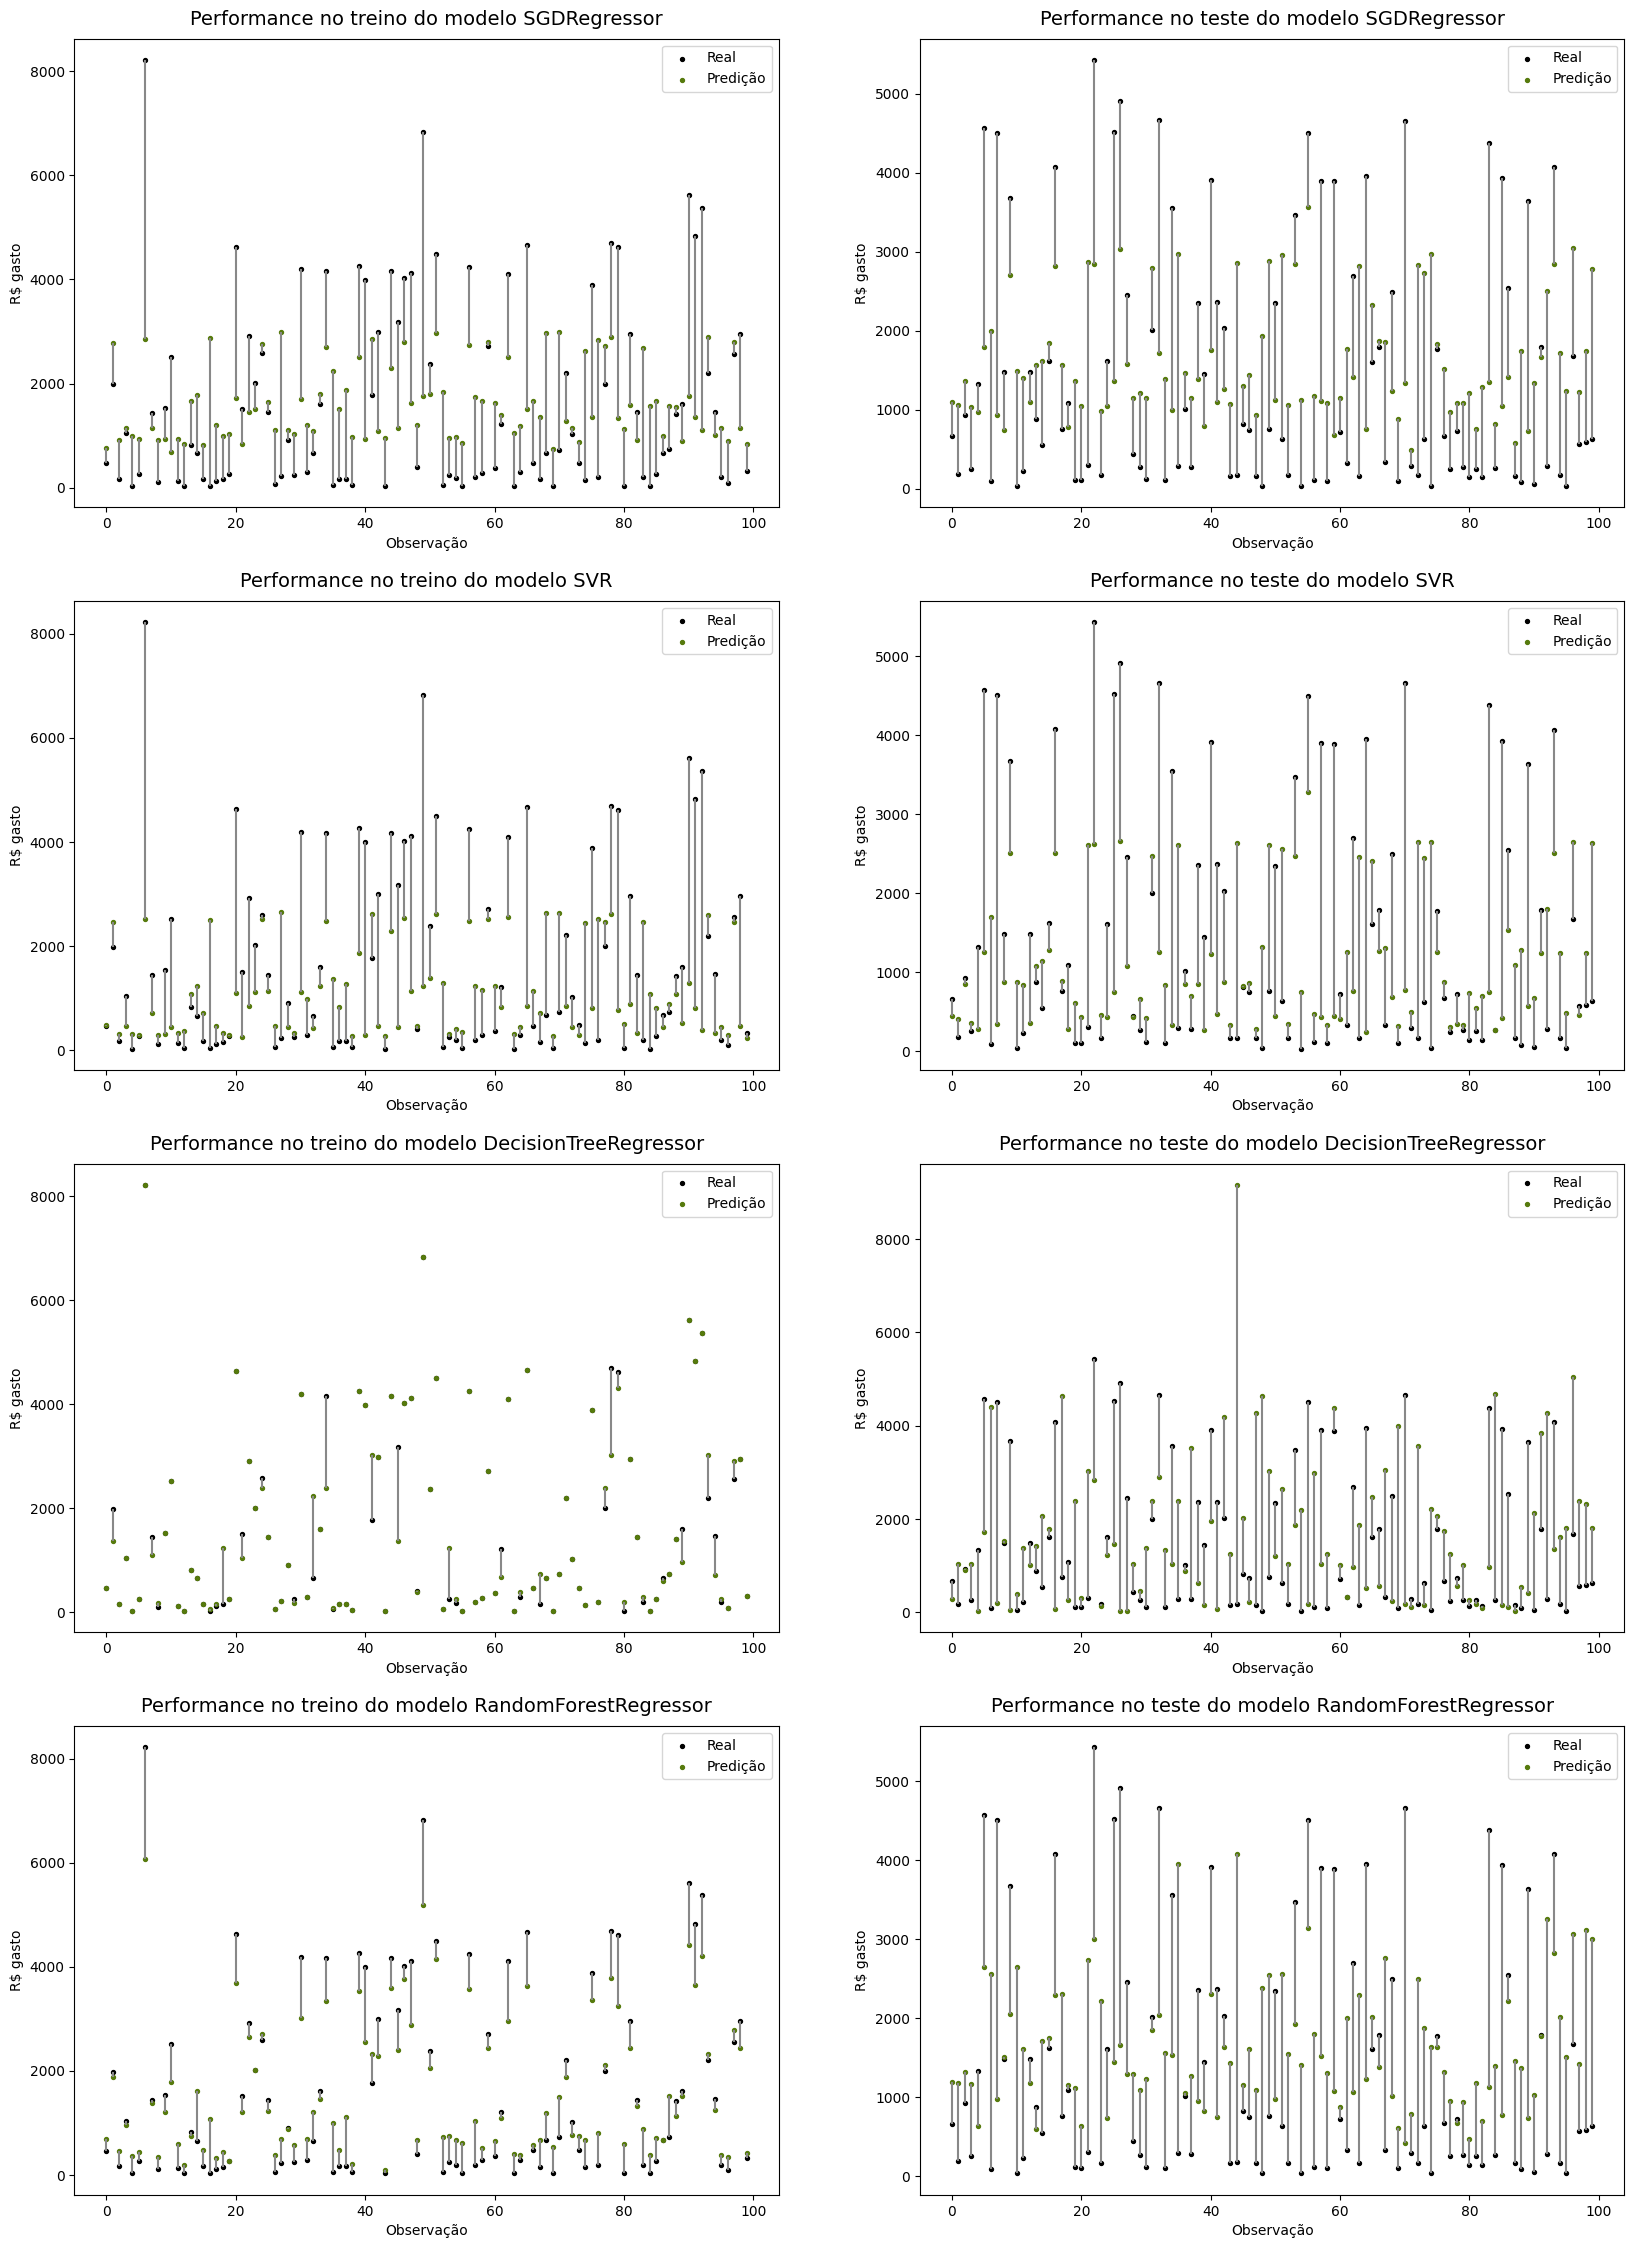

In [174]:
dataset = pd.read_csv(f"{BASE_PATH}/data/ml/ecommerce - python - gasto dos clientes.csv")
#dataset = dataset.loc[dataset["Total Pago (R$)"] < 3500]
pipe = Pipe(dataset)
pipe.set_encoder(TargetEncoder())
pipe.split(test=0.3)

pipe.set_target_column("Total Pago (R$)")
pipe.set_categorical_columns(["Perfil do Cliente", "Campanha em Curso"])
pipe.set_numeric_columns([
    "Desconto Total (%)",
    "Tempo desde a Última Compra (dias)",
    "Tempo para Finalizar Compra (min)"
])
pipe.fit_preprocess()

print("Testando modelo linear")
linear_model = SGDRegressor(loss="squared_error", penalty=None, alpha=0.001, eta0=0.001, learning_rate="optimal")
pipe.train_model(linear_model, remove_outliers=False)

print("\nTestando modelo de máquinas de suporte")
svm_model = SVR(kernel="linear", C=10, epsilon=0.1)
pipe.train_model(svm_model, remove_outliers=False)

print("\nTestando modelo de árvore de decisão")
dt_model = DecisionTreeRegressor(max_depth=20)
pipe.train_model(dt_model, remove_outliers=False)

print("\nTestando o modelo de florestas")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=50)
pipe.train_model(rf_model, remove_outliers=False)

pipe.show_graphs([linear_model, svm_model, dt_model, rf_model])

## Utilizando o modelo

Ao passarmos por todo o processo de ajuste, podemos finalmente utilizar nosso modelo para ativamente prever o comportamento de um cliente qualquer em uma situação que definirmos. Em outras palavras, podemos testar cenários diversos para um mesmo cliente. Por exemplo, podemos variar o tempo gasto para fechar a compra ou o tempo desde a última vez que ele fez alguma compra. Isso pode gerar direcionamentos para o time de marketing, que vai saber passar a ter metas numéricas para perseguir e alcançar melhores resultados.

Por exemplo, tomando o nosso cliente mais "importante" (consome mais), será que ao reduzir o tempo de decisão na compra faz com que ele gaste mais? Sabendo que em média os consumidores deste perfil fecham suas compras com 15 minutos, conseguimos fazer eles comprarem mais se reduzirmos este tempo para 10? E se reduzirmos para 5? Assim, uma boa meta para o time de vendas poderia ser fazer com que esses clientes finalizem a compra mais rápido, esperando um aumento aproximado de R$ 100,00 por compra. Dessa forma, temos uma aplicação de ML dentro de um modelo de negócio, traçando com elas metas mais claras e objetivas. Isso é ser data driven, o que tando se fala recentemente.

In [155]:
columns = [
    "Perfil do Cliente", "Campanha em Curso", "Desconto Total (%)",
    "Tempo desde a Última Compra (dias)", "Tempo para Finalizar Compra (min)"
]
cases = [
    ["Médio ticket e alta frequência", "Eletrodomésticos", 1, 10, 15],
    ["Médio ticket e alta frequência", "Eletrodomésticos", 1, 10, 10],
    ["Médio ticket e alta frequência", "Eletrodomésticos", 1, 10, 5],

    ["Médio ticket e alta frequência", "Livros", 1, 10, 15],
    ["Médio ticket e alta frequência", "Livros", 1, 10, 10],
    ["Médio ticket e alta frequência", "Livros", 1, 10, 5],

    ["Médio ticket e alta frequência", "Livros", 1, 10, 15],
    ["Médio ticket e alta frequência", "Livros", 1, 20, 15],
    ["Médio ticket e alta frequência", "Livros", 1, 30, 15]
]
pipe.predict(pd.DataFrame(cases, columns=columns), linear_model)

array([1847.16278119, 1896.48900483, 1945.81522847, 1847.16278119,
       1896.48900483, 1945.81522847, 1847.16278119, 1743.99678996,
       1640.83079872])